In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas_datareader.yahoo.daily import YahooDailyReader
import pandas_datareader as web

from pypfopt.discrete_allocation import DiscreteAllocation

In [2]:
# tickers = ['NOVA', 'BEPC', 'CIO', 'JOE', 'CC', 'KWR', 'NET', 'BTRS', 'DXCM', 'MNKD', 'AJRD', 'CARR', 'AUB', 'UWMC', 
#            'CPE', 'FRO', 'TTCF', 'TSN', 'F', 'LNW', 'LUMN', 'GOGO']

# tickers = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'IYE', 'ITB', 'IYR', 'XLB', 'KBE', 'XHB', 'XME', 'XOP', 'KRE',
#            'XTL', 'XTL', 'XLK', 'XLU', 'GDX', 'GDXJ', 'OIH', 'SMH', 'VNQ']

tickers = ['ETLX.DE', 'IBCI.DE', 'G2X.DE', '2B78.DE', 'XDW0.DE', 'VOOM.DE', 'IS0D.DE', 'FLXG.DE', 'SPYY.DE', 
           'IUSL.DE', 'XDEB.DE', 'EUNL.DE', 'XDWD.DE', 'XDEQ.DE', 'EMWE.DE', 'USPY.DE', 'WTEM.DE', 'XDWH.DE', 
           'XDWT.DE']


# portfolio_type = "stock"
# portfolio_type = "etf_usa"
portfolio_type = "etf_ge"

start='01/01/2021'
end='12/31/2021'

total_portfolio_value = 50000

buy_date = '01/03/2022'
buy_date_week_end = '01/10/2022'
buy_date_month_end = '02/03/2022'

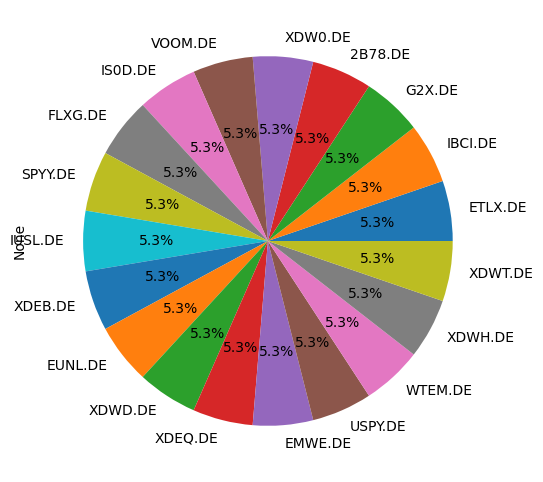

In [3]:
#naive_distribution weights
cleaned_weights = {key : 1/len(tickers) for key in tickers}
weights_list = list(cleaned_weights.values())

fig = pd.Series(cleaned_weights).plot.pie(figsize=(6,6), autopct='%1.1f%%').get_figure()
fig.savefig("results/Naive/cleaned_weights_"+portfolio_type+".png")

In [4]:
data_new = YahooDailyReader(symbols=tickers, 
                        start=buy_date, end=buy_date, 
                        retry_count=3, pause=0.1, session=None, adjust_price=False, ret_index=False, 
                        chunksize=1, interval='d', get_actions=False, adjust_dividends=True)
new_df = data_new.read()

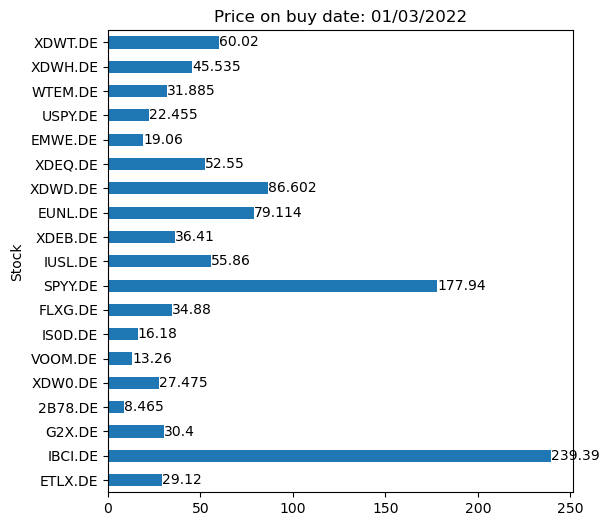

In [5]:
price_map = {}
for col in new_df['Open']:
    price_map[col] = new_df['Open'][col].iloc[0]
ax = pd.Series(price_map).plot.barh(figsize = (6,6), ylabel='Price', xlabel='Stock', title="Price on buy date: " + buy_date)
ax.bar_label(ax.containers[0])
ax.get_figure().savefig("results/Naive/prices_buy_date_"+portfolio_type+".png")

In [6]:
price_map_pd = pd.Series(price_map.values(), index=price_map.keys())
da = DiscreteAllocation(cleaned_weights, price_map_pd, total_portfolio_value=total_portfolio_value)

allocation, leftover = da.greedy_portfolio()
print("Allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Allocation: {'ETLX.DE': 90, 'IBCI.DE': 11, 'G2X.DE': 86, '2B78.DE': 311, 'XDW0.DE': 96, 'VOOM.DE': 198, 'IS0D.DE': 162, 'FLXG.DE': 75, 'SPYY.DE': 15, 'IUSL.DE': 47, 'XDEB.DE': 72, 'EUNL.DE': 33, 'XDWD.DE': 31, 'XDEQ.DE': 50, 'EMWE.DE': 138, 'USPY.DE': 117, 'WTEM.DE': 82, 'XDWH.DE': 58, 'XDWT.DE': 44}
Funds remaining: $5.70


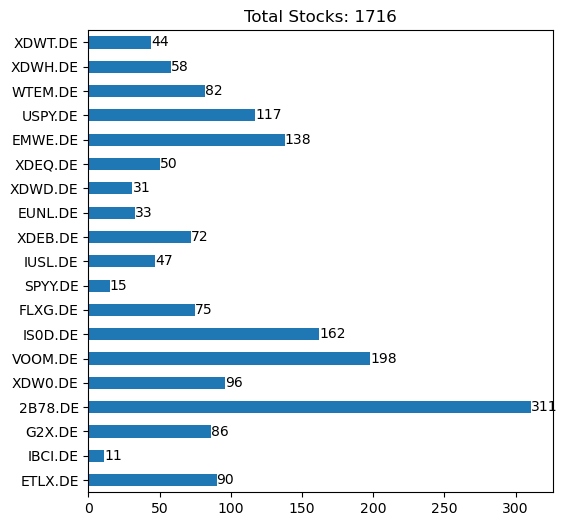

In [7]:
# pd.Series(share_allocations).plot.pie(figsize=(6,6), autopct='%1.1f%%')
ax = pd.Series(allocation).plot.barh(figsize=(6,6), title="Total Stocks: "+ str(sum(allocation.values())))
ax.bar_label(ax.containers[0])
ax.get_figure().savefig("results/Naive/allocation_"+portfolio_type+".png")

In [8]:
data_weekly = YahooDailyReader(tickers, start=buy_date, end=buy_date_week_end, 
                        retry_count=3, pause=0.1, session=None, adjust_price=False, ret_index=False, 
                        chunksize=1, interval='d', get_actions=False, adjust_dividends=True)
df_weekly = data_weekly.read()


data_monthly = YahooDailyReader(tickers, start=buy_date, end=buy_date_month_end, 
                        retry_count=3, pause=0.1, session=None, adjust_price=False, ret_index=False, 
                        chunksize=1, interval='d', get_actions=False, adjust_dividends=True)
df_monthly = data_monthly.read()

In [9]:
df_monthly = df_monthly.dropna()

In [10]:
def open_price_extraction(df):
    price_map_open = {}
    for col in df['Open']:
        price_map_open[col] = df['Open'][col].iloc[0]
    return(price_map_open)

def allocations(price_map, total_portfolio_value):

    price_map_pd = pd.Series(price_map.values(), index=price_map.keys())
    da = DiscreteAllocation(cleaned_weights, price_map_pd, total_portfolio_value)
    allocation, leftover = da.greedy_portfolio()
    return allocation

In [11]:
def close_price_extraction(df):
    price_map_close = {}
    for col in df['Close']:
        price_map_close[col] = df['Close'][col].iloc[-1]
#     print('Closing prices for the period: ',price_map_close, end='\n\n')
    return(price_map_close)

def returns_calc(price_map_close, allocation, total_portfolio_value):
    close_value = sum(price_map_close[key] * allocation[key] for key in allocation)
    returns = ((close_value - total_portfolio_value)/total_portfolio_value)*100
    print(f'Returns for the period: {returns}%',end='\n\n')
    return round(returns,2)

In [12]:
print('--Weekly returns data--\n')
weekly_open = open_price_extraction(df_weekly)
weekly_allocations = allocations(weekly_open, total_portfolio_value)
weekly_close = close_price_extraction(df_weekly)
weekly_returns = returns_calc(weekly_close, weekly_allocations, total_portfolio_value)

--Weekly returns data--

Returns for the period: -1.897059952735901%



In [13]:
print('--Monthly returns data--\n')
monthly_open = open_price_extraction(df_monthly)
monthly_allocations = allocations(monthly_open, total_portfolio_value)
monthly_close = close_price_extraction(df_monthly)
monthly_returns = returns_calc(monthly_close, monthly_allocations, total_portfolio_value)

--Monthly returns data--

Returns for the period: -5.072137415885925%



In [14]:
df_weekly_ret = df_weekly['Adj Close'].pct_change(1).dropna() 

ret = dict(df_weekly_ret.mean())
temp_ret = sum([ret[k]*cleaned_weights[k] for k in ret if k in cleaned_weights])

sd = dict(df_weekly_ret.std())
temp_sd = [sd[k]*cleaned_weights[k] for k in sd if k in cleaned_weights]
exp_sd = sum(temp_sd)

# Calculate the Sharpe Ratio.
sharpe_ratio_weekly = round(temp_ret / exp_sd, 2)
print(sharpe_ratio_weekly)

-0.2


In [15]:
sd = dict(df_weekly_ret.std())
temp_sd = [sd[k]*cleaned_weights[k] for k in sd if k in cleaned_weights]
exp_sd = sum(temp_sd)
print(exp_sd)

0.012922996786133704


In [16]:
df_monthly_ret = df_monthly['Adj Close'].pct_change(1).dropna()

ret = dict(df_monthly_ret.mean())
temp_ret = sum([ret[k]*cleaned_weights[k] for k in ret if k in cleaned_weights])

sd = dict(df_monthly_ret.std())
temp_sd = [sd[k]*cleaned_weights[k] for k in sd if k in cleaned_weights]
exp_sd = sum(temp_sd)

# Calculate the Sharpe Ratio.
sharpe_ratio_monthly = round(temp_ret / exp_sd,2)
print(sharpe_ratio_monthly)

-0.13


In [17]:
starts = ['01/01/2022', '02/01/2022', '03/01/2022', '04/01/2022', '05/01/2022', '06/01/2022', '07/01/2022', 
          '08/01/2022', '09/01/2022', '10/01/2022', '11/01/2022', '12/01/2022']

df_monthly_ret = df_monthly['Adj Close'].pct_change(1).dropna()

ret = dict(df_monthly_ret.mean())
temp_ret = sum([ret[k]*cleaned_weights[k] for k in ret if k in cleaned_weights])

sd = dict(df_monthly_ret.std())
temp_sd = [sd[k]*cleaned_weights[k] for k in sd if k in cleaned_weights]
exp_sd = sum(temp_sd)

# Calculate the Sharpe Ratio.
sharpe_ratio_monthly = round(temp_ret / exp_sd,2)
print(sharpe_ratio_monthly)

-0.13


In [18]:
d = {'Index Title': ['weekly', 'monthly']}#, 'Sortino Ratio'
dump_df = pd.DataFrame(d).set_index('Index Title')
dump_df['% Return'] = [weekly_returns, monthly_returns]
dump_df['Sharpe Ratio'] = [sharpe_ratio_weekly, sharpe_ratio_monthly]
dump_df

,% Return,Sharpe Ratio
Index Title,,
weekly,-1.90,-0.20
monthly,-5.07,-0.13


In [19]:
import pickle

with open("metrics_"+portfolio_type+".pickle","wb") as f:
    pickle.dump(dump_df, f)

In [20]:
price_data = web.get_data_yahoo(tickers, start=buy_date, end='12/01/2022')
price_data = price_data['Adj Close']

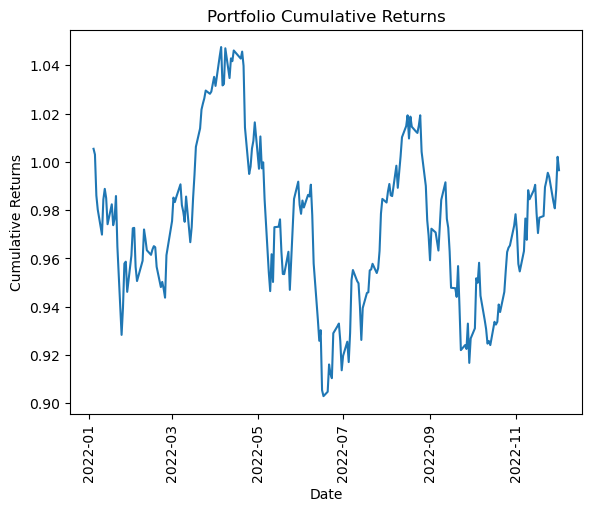

In [21]:
returns_data = price_data.pct_change()[1:]
weighted_returns = (cleaned_weights * returns_data)

portfolio_returns = weighted_returns.sum(axis=1)
cumulative_ret = (portfolio_returns + 1).cumprod()

fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(cumulative_ret)
ax1.set_xlabel('Date')
ax1.set_ylabel("Cumulative Returns")
ax1.set_title("Portfolio Cumulative Returns")
plt.xticks(rotation = 90)
plt.savefig("results/Naive/cumm_returns_"+portfolio_type+".png")
plt.show()

with open("results/Naive/cum_return_"+portfolio_type+".pickle","wb") as f:
    pickle.dump(cumulative_ret, f)

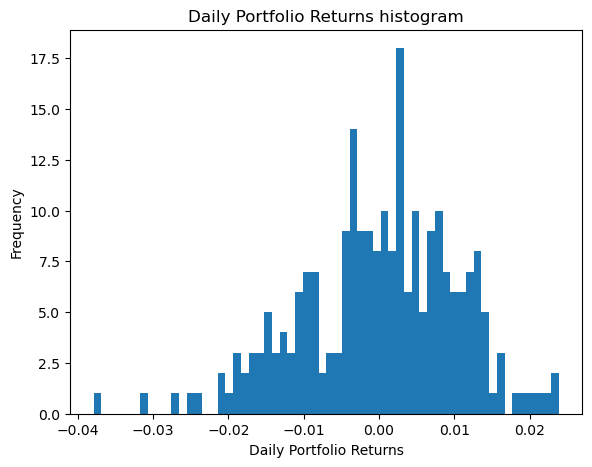

In [22]:
returns_data = price_data.pct_change()[1:]
weighted_returns = cleaned_weights * returns_data
portfolio_returns = weighted_returns.sum(axis=1)

fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.hist(portfolio_returns, bins = 60)
ax1.set_xlabel('Daily Portfolio Returns')
ax1.set_ylabel("Frequency")
ax1.set_title("Daily Portfolio Returns histogram")
plt.savefig("results/Naive/returns_histogram_" + portfolio_type + ".png")
plt.show(); 

with open("results/Naive/weighted_return_"+portfolio_type+".pickle","wb") as f:
    pickle.dump(weighted_returns, f)

In [26]:
import datetime

TypeError: function missing required argument 'month' (pos 2)